In [110]:
import torch
import random
import numpy as np
from deepSVDD import DeepSVDD
from datasets.main import load_dataset
from base.base_dataset import BaseADDataset
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.utils import resample

In [111]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        """
        初始化 Dataset
        :param data: 已處理的特徵數據 (NumPy array or Pandas DataFrame)
        :param labels: 對應的標籤數據
        """
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        """返回數據集大小"""
        return len(self.data)

    def __getitem__(self, idx):
        """根據索引返回一筆數據及其標籤"""
        return self.data[idx], self.labels[idx], idx

class MyADDataset(BaseADDataset):
    def __init__(self):
        super().__init__(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')

    def process_data(self, file_path):
        # 讀取資料
        df=pd.read_csv(r'multiclass15\csv_result-data1 Sampled Scenarios.csv')
        for i in range(2, 16):
            tmp = pd.read_csv(r'multiclass15\csv_result-data'+str(i)+' Sampled Scenarios.csv')
            df = pd.concat([df, tmp], ignore_index=True)
        
        # df = pd.read_csv(file_path)
        df = df.replace([np.inf, -np.inf], np.nan).dropna()
        df = df.drop('id', axis=1)
        
        # 標籤處理
        y = df['marker']
        y = [0 if value in [41] else 1 for value in y]
        X = df.drop('marker', axis=1)

        # 刪除不必要的欄位
        columns_to_drop = ['control_panel_log1', 'control_panel_log2', 'control_panel_log3', 
                        'control_panel_log4', 'relay1_log', 'relay2_log', 'relay3_log', 
                        'relay4_log', 'snort_log1', 'snort_log2', 'snort_log3', 'snort_log4']
        X = X.drop(columns=columns_to_drop, axis=1)
        
        # 分割數據集
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, stratify=y, random_state=42
        )

        # PCA 降維
        # pca = PCA(n_components=15)
        # X_train = pca.fit_transform(X_train)
        # X_test = pca.transform(X_test)

        X_train_df = pd.DataFrame(X_train)
        y_train_df = pd.DataFrame(y_train, columns=['label'])

        X_train_df.reset_index(drop=True, inplace=True)
        y_train_df.reset_index(drop=True, inplace=True)

        merged_df = pd.concat([X_train_df, y_train_df], axis=1)
        
        label_0_data = merged_df[merged_df['label'] == 0]
        train_data = label_0_data.drop('label', axis=1)

        # Min-Max 標準化
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(train_data)
        X_test = scaler.transform(X_test)

        return X_train, X_test, y_train, y_test

    def create_dataloaders(self, file_path, batch_size=32, num_workers=0):
        # 處理數據
        X_train, X_test, y_train, y_test = self.process_data(file_path)

        # 建立 Dataset
        train_dataset = CustomDataset(X_train, y_train)
        test_dataset = CustomDataset(X_test, y_test)

        # 建立 DataLoader
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        return train_loader, test_loader
    
    def loaders(self, batch_size, shuffle_train=True, shuffle_test=False, num_workers = 0):
        train_loader, test_loader = self.create_dataloaders(self.root, batch_size=batch_size)
        return train_loader, test_loader


def test_deep_svdd():
    # 隨便填一些測試參數
    net_name = 'feature_net'
    normal_class = 0
    nu = 0.1
    objective = 'one-class'
    device = 'cuda'

    print("開始測試 DeepSVDD...")

    # 初始化 DeepSVDD 並設定網路
    deep_svdd = DeepSVDD(objective, nu)
    deep_svdd.set_network(net_name)

    data = MyADDataset()

    # 測試 train
    print("開始訓練...")
    deep_svdd.train(
        data,
        optimizer_name='adam',
        lr=0.001,
        n_epochs=100, 
        lr_milestones=[],
        batch_size=64,
        weight_decay=1e-6,
        device=device,
        n_jobs_dataloader=0
    )
    print("訓練完成。")

    # 測試 test
    print("開始測試...")
    deep_svdd.test(data, device=device, n_jobs_dataloader=0)

    print("測試完成。")

    return deep_svdd.results, deep_svdd.getNet(), data

In [112]:
results, net, dataset = test_deep_svdd()

開始測試 DeepSVDD...
開始訓練...


c:\Users\user\AppData\Local\anaconda3\envs\DeepSVDD\Lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


訓練完成。
開始測試...
測試完成。


In [113]:
def get_hyperFeature(TrainTest):
    net.eval()
    train_loader, test_loader = dataset.loaders(batch_size=64, num_workers=0)
    hyperFeature = []

    if TrainTest == 'train':
        loader = train_loader
    else:
        loader = test_loader

    with torch.no_grad():
        for data in loader:
            inputs, labels, idx = data
            inputs = inputs.to('cuda')

            # 找到你了 小調皮
            outputs = net(inputs)

            hyperFeature.append(outputs.cpu().numpy())

    hyperFeatureNP = np.vstack(hyperFeature)
    return hyperFeatureNP

In [114]:
trainHF = get_hyperFeature('train')
testHF = get_hyperFeature('test')

print(trainHF)
print(testHF)

[[ 0.09987342 -0.09978636 -0.0998745  ... -0.20854695 -0.09999313
   0.1852889 ]
 [ 0.09996787 -0.09983845 -0.099914   ... -0.20863713 -0.10001308
   0.18531075]
 [ 0.09994273 -0.09984907 -0.09990669 ... -0.20856264 -0.10003863
   0.18519358]
 ...
 [ 0.09969851 -0.09979032 -0.09988879 ... -0.20861682 -0.09992482
   0.18524432]
 [ 0.09973007 -0.09975405 -0.09987319 ... -0.20863792 -0.09991501
   0.1852597 ]
 [ 0.09960327 -0.09977754 -0.09987839 ... -0.20864643 -0.09988095
   0.18518953]]
[[ 0.09959175 -0.09973939 -0.09985434 ... -0.20855042 -0.09986448
   0.1851616 ]
 [ 0.09853089 -0.09934434 -0.09984169 ... -0.20864283 -0.09919743
   0.18544555]
 [ 0.12797627 -0.10647198 -0.10181862 ... -0.20674951 -0.11484048
   0.18503135]
 ...
 [ 0.09903548 -0.09951541 -0.09983316 ... -0.20864905 -0.09947581
   0.1852124 ]
 [ 0.09958688 -0.0997375  -0.09987042 ... -0.20862687 -0.09989927
   0.18516433]
 [ 0.09889276 -0.09945866 -0.09984486 ... -0.2086578  -0.0994103
   0.18522598]]


In [115]:
from sklearn.ensemble import IsolationForest

# Initialize the Isolation Forest model
iso_forest = IsolationForest(contamination=0.1, random_state=42, n_estimators= 130, bootstrap=True, max_features=7)

# Fit the model on the hyperFeatureNP data
iso_forest.fit(trainHF)

# Predict anomalies
anomaly_scores = iso_forest.decision_function(testHF)
anomalies = iso_forest.predict(testHF)

# Convert predictions to binary labels (1 for normal, -1 for anomaly)
anomalies = [1 if x == -1 else 0 for x in anomalies]

# Print the number of detected anomalies
print(f"Number of detected anomalies: {sum(anomalies)}")

from sklearn.metrics import roc_auc_score, precision_score
# Calculate AUC-ROC

y_true = []
_, test_loader = dataset.loaders(batch_size=64, num_workers=0)
for data in test_loader:
    _, labels, _ = data
    y_true.append(labels.cpu().numpy())

y_true = np.hstack(y_true)

auc_roc = roc_auc_score(y_true, -anomaly_scores)
print(f"AUC-ROC: {auc_roc}")

Number of detected anomalies: 12319
AUC-ROC: 0.9531737196285573


In [116]:
# param_grid = {
#     'n_estimators' : [10, 20 ,30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200],
#     'bootstrap' : [True, False],
#     'max_features' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# }

In [117]:
# n_iter = 3000  # 設定測試次數
# best_params = None
# best_score = -np.inf
# try:
#     for i in range(n_iter):
#         # 隨機選取參數
#         params = {key: random.choice(values) for key, values in param_grid.items()}

#         # 初始化模型
#         iso_forest = IsolationForest(random_state=42, n_estimators=params['n_estimators'], bootstrap=params['bootstrap'], max_features=params['max_features'])

#         # 訓練模型
#         iso_forest.fit(trainHF)

#         # 預測異常
#         anomaly_scores = iso_forest.decision_function(testHF)

#         # 計算 AUC-ROC
#         auc_roc = roc_auc_score(y_true, -anomaly_scores)

#         # 更新最佳參數
#         if auc_roc > best_score:
#             best_score = auc_roc
#             best_params = params

#         print(f"Iteration {i+1}/{n_iter} - AUC-ROC: {auc_roc}")

#     print(f"Best parameters: {best_params}")
#     print(f"Best AUC-ROC: {best_score}")

# except KeyboardInterrupt:
#     pass

# # 輸出最佳結果
# print("\nBest Parameters:", best_params)
# print("Best ROC-AUC:", best_score)

In [155]:
trainScore = iso_forest.decision_function(trainHF)

threshold = np.percentile(trainScore, 50)

In [156]:
threshold

0.08925901836077979

In [157]:
thresholdAnomalies = []
for i in range(len(anomaly_scores)):
    if anomaly_scores[i] < threshold:
        thresholdAnomalies.append(1)
    else:
        thresholdAnomalies.append(0)

In [158]:
thresholdAnomalies.count(0)

750

Accuracy: 0.947485258411377
F1 Score: 0.9721680944152359
Precision: 0.9675082327113063
Recall: 0.9768730604403724


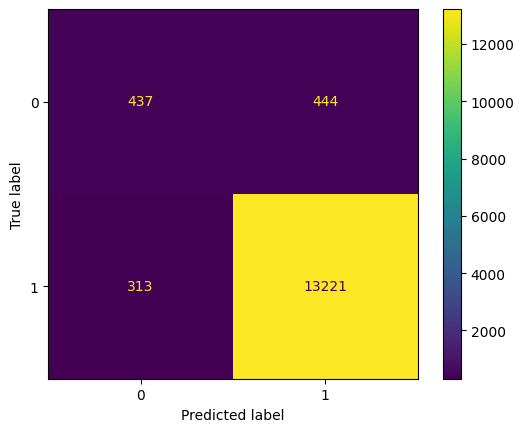

In [159]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate accuracy
accuracy = accuracy_score(y_true, thresholdAnomalies)

# Calculate F1 score
f1 = f1_score(y_true, thresholdAnomalies)

precision = precision_score(y_true, thresholdAnomalies)

recall = recall_score(y_true, thresholdAnomalies)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

# Assuming y_test and y_pred are defined
cm = confusion_matrix(y_true, thresholdAnomalies)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [160]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Calculate accuracy
accuracy = accuracy_score(y_true, anomalies)

# Calculate F1 score
f1 = f1_score(y_true, anomalies)

precision = precision_score(y_true, anomalies)

recall = recall_score(y_true, anomalies)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Accuracy: 0.902670828997572
F1 Score: 0.9457316365605539
Precision: 0.9923695105122169
Recall: 0.9032806265701196


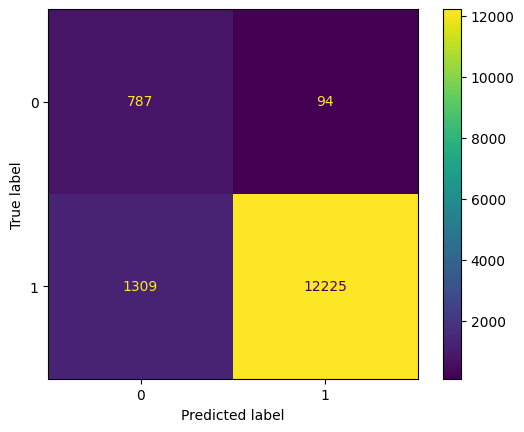

In [161]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are defined
cm = confusion_matrix(y_true, anomalies)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

In [162]:
train_loader, test_loader = dataset.loaders(batch_size=64, num_workers=0)
X_train = []
X_test = []
y_test = []
for data in train_loader:
    inputs, labels, idx = data
    X_train.append(inputs.cpu().numpy())

for data in test_loader:
    inputs, labels, idx = data
    X_test.append(inputs.cpu().numpy())
    y_test.append(labels.cpu().numpy())

X_train = np.vstack(X_train)
X_test = np.vstack(X_test)
y_test = np.hstack(y_test)